#Project Intro & Goals
Home and Garden Product Search Relevance Prediction

This project focuses on developing a machine learning model to rate the relevance of search results for home and garden products. Our goal is to create a system that can accurately match search queries with product information, considering factors such as brand, material, and functionality.

To illustrate what we're trying to achieve, let's look at a couple of examples:

1. High Relevance Example:
   Search term: "angle bracket"
   Product: Simpson Strong-Tie 12-Gauge Angle
   Relevance Score: 3.0 (Perfect match)

   The product description mentions: "Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses..."
   
   This is a perfect match because the search term directly corresponds to the product, and the description confirms its purpose and brand.

2. Lower Relevance Example:
   Search term: "honda mower"
   Product: Toro Personal Pace Recycler 22 in. Variable Speed Self-Propelled Gas Lawn Mower with Briggs & Stratton Engine
   Relevance Score: 2.0 (Partially relevant)

   While this product is a lawn mower, it's not a Honda brand. It's partially relevant because it's the right type of product (a mower) but doesn't match the specific brand requested.

Our model aims to predict these relevance scores by analyzing the relationship between search terms, product titles, and detailed product information. We'll be working with a dataset that includes search queries, product titles, descriptions, and attributes. Through data preprocessing, feature engineering, and the application of various machine learning techniques, we aim to build a model that can distinguish between irrelevant, partially relevant, and perfectly matching results.

The ultimate objective is to improve the search experience on e-commerce platforms specializing in home improvement and gardening products by providing more accurate and relevant search results. This notebook will walk through the entire process, from data exploration and cleaning to model development and evaluation, showcasing the steps taken to address this real-world information retrieval challenge.



In [1]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.7 MB/s eta 0:00:00


In [2]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import Levenshtein
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize stemmer, lemmatizer, and stopwords
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Set up matplotlib for inline plotting in notebooks
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Here, we load the datasets: train, test, attributes, and product descriptions. This gives us a comprehensive view of the product information and search queries we'll be working with. The absence of missing values in the train and test sets is a good sign for data quality.

In [3]:
# Load datasets
train_df = pd.read_csv("train.csv", encoding="ISO-8859-1")
test_df = pd.read_csv("test.csv", encoding="ISO-8859-1")
attributes_df = pd.read_csv('attributes.csv', engine='python')
descriptions_df = pd.read_csv('product_descriptions.csv', engine='python')

# Check for missing values
for name, df in [('Train', train_df), ('Test', test_df), ('Attributes', attributes_df), ('Descriptions', descriptions_df)]:
    print(f"\nMissing values in {name} dataset:")
    print(df.isnull().sum())
    print(f"\n{name} Dataset Info:")
    print(df.info())
    print("\nSample data:")
    display(df.head())
    print("\n" + "="*50)


Missing values in Train dataset:
id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74067 non-null  int64  
 1   product_uid    74067 non-null  int64  
 2   product_title  74067 non-null  object 
 3   search_term    74067 non-null  object 
 4   relevance      74067 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB
None

Sample data:


,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67




Missing values in Test dataset:
id               0
product_uid      0
product_title    0
search_term      0
dtype: int64

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             166693 non-null  int64 
 1   product_uid    166693 non-null  int64 
 2   product_title  166693 non-null  object
 3   search_term    166693 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
None

Sample data:


,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668




Missing values in Attributes dataset:
product_uid     155
name            155
value          6422
dtype: int64

Attributes Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044803 entries, 0 to 2044802
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   product_uid  float64
 1   name         object 
 2   value        object 
dtypes: float64(1), object(2)
memory usage: 46.8+ MB
None

Sample data:


,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel




Missing values in Descriptions dataset:
product_uid            0
product_description    0
dtype: int64

Descriptions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_uid          124428 non-null  int64 
 1   product_description  124428 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB
None

Sample data:


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


Dataset sizes:

Train dataset: 74,067 rows

Test dataset: 166,693 rows

Attributes dataset: 2,044,803 rows

Descriptions dataset: 124,428 rows

Original features:

Train dataset: 5 features (id, product_uid, product_title, search_term, relevance)

Test dataset: 4 features (id, product_uid, product_title, search_term)

#Visualizing the data:

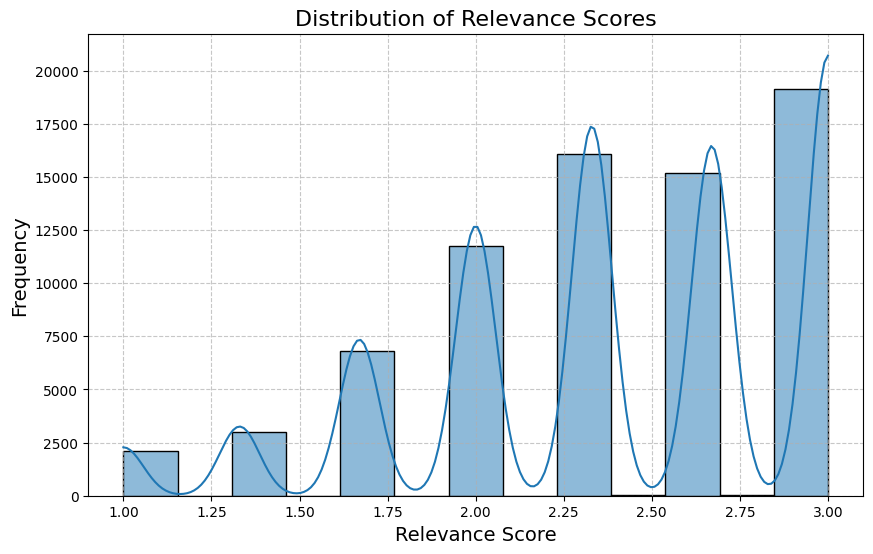

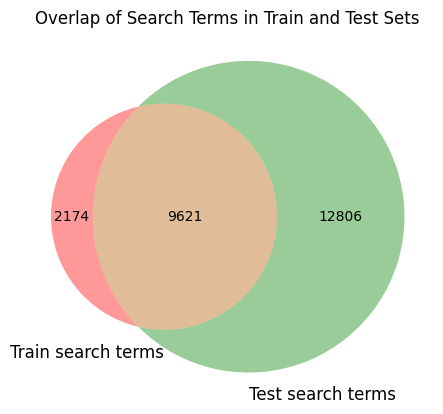

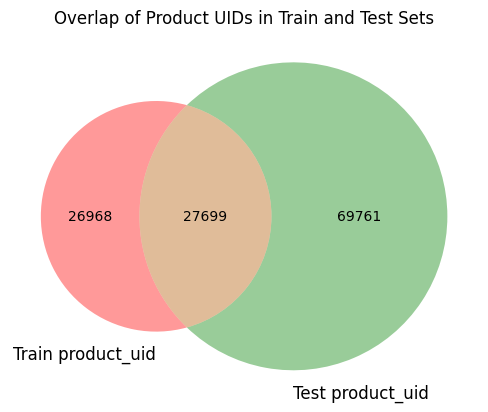

In [4]:
# Analyze relevance distribution in train dataset
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='relevance', bins=13, kde=True)
plt.title('Distribution of Relevance Scores', fontsize=16)
plt.xlabel('Relevance Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Compare search terms between train and test sets
train_search_terms = set(train_df['search_term'])
test_search_terms = set(test_df['search_term'])
venn2([train_search_terms, test_search_terms], ('Train search terms', 'Test search terms'))
plt.title('Overlap of Search Terms in Train and Test Sets')
plt.show()

# Compare product_uid between train and test sets
train_product_uids = set(train_df['product_uid'])
test_product_uids = set(test_df['product_uid'])
venn2([train_product_uids, test_product_uids], ('Train product_uid', 'Test product_uid'))
plt.title('Overlap of Product UIDs in Train and Test Sets')
plt.show()

This histogram shows the distribution of relevance scores in the training data. We can see that the scores are not evenly distributed:

There's a peak at 3.0, indicating many perfect matches.
Another peak around 2.3-2.7, suggesting many partially relevant results.
Fewer scores below 2.0, implying that completely irrelevant results are less common.
This distribution suggests that the search algorithm is generally performing well, but there's room for improvement in distinguishing between partial and perfect matches.

These Venn diagrams show the overlap between train and test sets:

1.Search terms: There's significant overlap, but also many unique terms in each set. This suggests that our model needs to generalize well to new search queries.

2.Product UIDs: Almost all products in the train set are also in the test set, with many additional products in the test set. This indicates that our model will be evaluated on both familiar and new products.

In [38]:
def count_SR():
    high_SR = [relevance for relevance in train_df['relevance'] if relevance == 3.00]
    middle_SR = [relevance for relevance in train_df['relevance'] if 1.00 < relevance < 3.00]
    low_SR = [relevance for relevance in train_df['relevance'] if relevance == 1.00]
    return [len(high_SR), len(middle_SR), len(low_SR)]


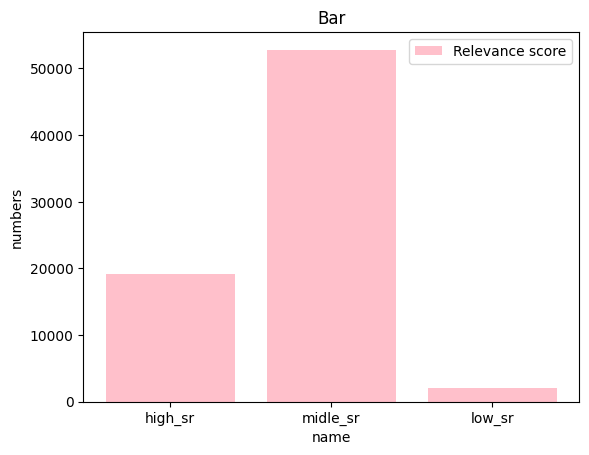

In [6]:
plt.bar(['high_sr', 'midle_sr', 'low_sr'], count_SR(), label='Relevance score', color='pink')
plt.xlabel('name')
plt.ylabel('numbers')
plt.title('Bar')
plt.legend()
plt.show()

These cells provide more detailed breakdowns of the relevance scores:

The bar chart shows the count of high, middle, and low relevance scores.
The count plot confirms the distribution we saw in the histogram.

These visualizations reinforce that partially relevant results are the most common, followed by perfect matches, with fewer irrelevant results.

<ipython-input-7-8f793203aa76>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="relevance", data=train_df, palette="Reds")


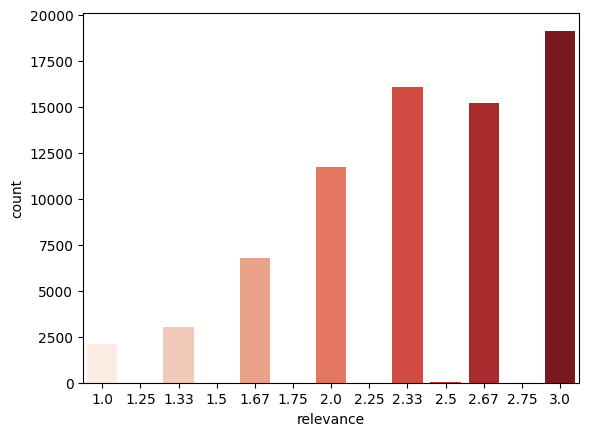

In [7]:
sns.countplot(x="relevance", data=train_df, palette="Reds")
plt.show()

#Cleaning the data:

This section is crucial for preparing our data for machine learning:

We clean the text data by removing special characters, standardizing abbreviations, and applying stemming and lemmatization.

We merge product descriptions with attributes to create a comprehensive product representation.

We handle missing values to ensure data completeness.
These steps are essential for creating meaningful features that capture the relationship between search queries and product information.

In [8]:
def remove_duplicates(string):
    unique_tokens = []
    [unique_tokens.append(str(token)) for token in string.split() if token not in unique_tokens]
    return ' '.join(unique_tokens)

def clean_text(text):
    text = str(text).lower()

    # Replace common abbreviations and remove specific strings
    replacements = {
        'in.': 'inch', 'ft.': 'foot', '-oz.': 'ounce', 'oz.': 'ounce',
        'sq.': 'square', 'gal.': 'gallon', 'lb.': 'pound', 'cu.': 'cubic',
        'o.d.': 'outer diameter', 'dia.': 'diameter', '-': '', 'r ': 'r'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    # Remove URLs and specific phrases
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'click here.*', '', text)
    text = re.sub(r'please visit.*', '', text)

    # Remove special characters and extra spaces
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    # Clean the text
    text = clean_text(text)

    # Remove stopwords
    words = [word for word in text.split() if word not in stop_words]

    # Lemmatize and stem
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]

    return ' '.join(words)

# Define strings to remove
strings_to_remove = [
    'br', 'src', 'href', 'alt', 'please visit',
    'Click here to review our return policy for additional information regarding returns',
    'Click here to see Home Depot',
    'Click here for our Project Guide',
    'Click here for our Buying Guide',
    'Click on the More Info tab to download',
    'CLICK HERE to create your own collection',
    'Click Here for details on the services',
    'Click Here for Ideas and Designs',
    'Click Here for a Demo of the Design',
    'Click Here to learn more about',
    'CLICK HERE to view our',
    'Click below to visit our',
    'Click here to purchase a sample of this',
    'click on the link to get started',
    'Click image to enlarge',
    'https://www.ryobitools.com/nation',
    'http://www.homedepot.com/ApplianceDeliveryandInstallation',
    'http://itemvideo-dev.microsite.homedepot.com/111414/26P/online_BB_banner_111114.jpg',
    'http://www.homedepot.com/p/Rev-A-Shelf-Door-Mounting-Kit-5WB-DMKIT/202855698'
]

Handle missing values and process attributes and descriptions:

In [9]:
# Handle missing values in attributes
attributes_df['value'].fillna('', inplace=True)

# Process attributes
attributes_df['name'] = attributes_df['name'].apply(lambda x: x[:6] if 'bullet' in str(x).lower() else x)
attributes_df['product_attributes'] = attributes_df['name'] + ' ' + attributes_df['value']
attributes_df = attributes_df.groupby('product_uid')['product_attributes'].apply(' '.join).reset_index()
attributes_df['clean_attributes'] = attributes_df['product_attributes'].apply(preprocess_text)
attributes_df['clean_attributes'] = attributes_df['clean_attributes'].apply(remove_duplicates)

# Process descriptions
for string in strings_to_remove:
    descriptions_df['product_description'] = descriptions_df['product_description'].apply(lambda x: x.lower().replace(string.lower(), ''))

descriptions_df['clean_description'] = descriptions_df['product_description'].apply(preprocess_text)

# Merge descriptions and attributes
df_des_attr = pd.merge(descriptions_df, attributes_df, on='product_uid', how='left')
df_des_attr['product_description_attributes'] = df_des_attr['clean_description'] + ' ' + df_des_attr['clean_attributes']

# Handle missing values in merged dataframe
df_des_attr['product_description_attributes'].fillna('', inplace=True)

print("Missing values after processing:")
print(df_des_attr.isnull().sum())

Missing values after processing:
product_uid                           0
product_description                   0
clean_description                     0
product_attributes                38165
clean_attributes                  38165
product_description_attributes        0
dtype: int64


In [10]:
df_des_attr.head(5)

,product_uid,product_description,clean_description,product_attributes,clean_attributes,product_description_attributes
0,100001,"not only do angles make joints stronger, they ...",angl make joint stronger also provid consist s...,Bullet Versatile connector for various 90° con...,bullet versatil connectorforvari 90 connect ho...,angl make joint stronger also provid consist s...
1,100002,behr premium textured deckover is an innovativ...,behrpremium textur deckoveri innov solid color...,"Application Method Brush,Roller,Spray Assemble...",applic method brush roller spray assembl depth...,behrpremium textur deckoveri innov solid color...
2,100003,classic architecture meets contemporary design...,classic architectur meet contemporari design e...,Built-in flange Yes Bullet Slightly narrower f...,builtin flang yes bullet slight narrowerfortig...,classic architectur meet contemporari design e...
3,100004,the grape solar 265-watt polycrystalline pv so...,grape solar265watt polycrystallin pv solarpane...,Amperage (amps) 8.56 Bullet Positive power tol...,amperag amp 8 56 bullet posit powertoler 0 5wa...,grape solar265watt polycrystallin pv solarpane...
4,100005,update your bathroom with the delta vero singl...,updat yourbathroom delta vero singlehandl show...,Bath Faucet Type Combo Tub and Shower Built-in...,bath faucet type combo tub showerbuiltin water...,updat yourbathroom delta vero singlehandl show...


Process train and test datasets:

In [11]:
# Function to process a single dataframe
def process_dataframe(df, df_des_attr):
    df['clean_title'] = df['product_title'].apply(preprocess_text)
    df['clean_search_term'] = df['search_term'].apply(preprocess_text)

    # Remove any existing 'product_description_attributes' column
    if 'product_description_attributes' in df.columns:
        df = df.drop('product_description_attributes', axis=1)

    # Merge with df_des_attr
    merged_df = pd.merge(df, df_des_attr[['product_uid', 'product_description_attributes']], on='product_uid', how='left')

    # Handle any missing values after merging
    merged_df['product_description_attributes'].fillna('', inplace=True)

    return merged_df

# Process train and test datasets
train_df = process_dataframe(train_df, df_des_attr)
test_df = process_dataframe(test_df, df_des_attr)

# Remove duplicate columns if they exist
for df in [train_df, test_df]:
    columns_to_drop = [col for col in df.columns if col.startswith('product_description_attributes_')]
    df.drop(columns=columns_to_drop, inplace=True)

# Print information about the processed datasets
for name, df in [('Train', train_df), ('Test', test_df)]:
    print(f"\nProcessing of {name} dataset completed.")
    print(f"Columns in {name} dataset:")
    print(df.columns)
    print(f"\nMissing values in processed {name} dataset:")
    print(df.isnull().sum())
    print(f"\nSample of processed {name} data:")
    display(df[['product_uid', 'clean_title', 'clean_search_term', 'product_description_attributes']].head())

print("\nData preprocessing completed.")

# Final verification
print("\nFinal Train dataset columns:")
print(train_df.columns)
print("\nFinal Test dataset columns:")
print(test_df.columns)

# Check if the column was added successfully
if 'product_description_attributes' in train_df.columns and 'product_description_attributes' in test_df.columns:
    print("\nThe 'product_description_attributes' column is present in both datasets.")
else:
    print("\nWarning: The 'product_description_attributes' column is missing from one or both datasets.")
    print("Train columns:", 'product_description_attributes' in train_df.columns)
    print("Test columns:", 'product_description_attributes' in test_df.columns)

# Additional check: print the number of rows in each dataset before and after merging
print("\nNumber of rows:")
print(f"Original train_df: {len(train_df)}")
print(f"Original test_df: {len(test_df)}")
print(f"df_des_attr: {len(df_des_attr)}")


Processing of Train dataset completed.
Columns in Train dataset:
Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'clean_title', 'clean_search_term', 'product_description_attributes'],
      dtype='object')

Missing values in processed Train dataset:
id                                0
product_uid                       0
product_title                     0
search_term                       0
relevance                         0
clean_title                       0
clean_search_term                 0
product_description_attributes    0
dtype: int64

Sample of processed Train data:


,product_uid,clean_title,clean_search_term,product_description_attributes
0,100001,simpson strongti 12gaug angl,angl bracket,angl make joint stronger also provid consist s...
1,100001,simpson strongti 12gaug angl,l bracket,angl make joint stronger also provid consist s...
2,100002,behrpremium textur deckover1gallon sc141 tugbo...,deck,behrpremium textur deckoveri innov solid color...
3,100005,delta vero 1handl showeron faucet trim kit chr...,rain showerhead,updat yourbathroom delta vero singlehandl show...
4,100005,delta vero 1handl showeron faucet trim kit chr...,showeron faucet,updat yourbathroom delta vero singlehandl show...



Processing of Test dataset completed.
Columns in Test dataset:
Index(['id', 'product_uid', 'product_title', 'search_term', 'clean_title',
       'clean_search_term', 'product_description_attributes'],
      dtype='object')

Missing values in processed Test dataset:
id                                0
product_uid                       0
product_title                     0
search_term                       0
clean_title                       0
clean_search_term                 0
product_description_attributes    0
dtype: int64

Sample of processed Test data:


,product_uid,clean_title,clean_search_term,product_description_attributes
0,100001,simpson strongti 12gaug angl,90 degre bracket,angl make joint stronger also provid consist s...
1,100001,simpson strongti 12gaug angl,metal l bracket,angl make joint stronger also provid consist s...
2,100001,simpson strongti 12gaug angl,simpson sku abl,angl make joint stronger also provid consist s...
3,100001,simpson strongti 12gaug angl,simpson strong tie,angl make joint stronger also provid consist s...
4,100001,simpson strongti 12gaug angl,simpson strong tie hcc668,angl make joint stronger also provid consist s...



Data preprocessing completed.

Final Train dataset columns:
Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'clean_title', 'clean_search_term', 'product_description_attributes'],
      dtype='object')

Final Test dataset columns:
Index(['id', 'product_uid', 'product_title', 'search_term', 'clean_title',
       'clean_search_term', 'product_description_attributes'],
      dtype='object')

The 'product_description_attributes' column is present in both datasets.

Number of rows:
Original train_df: 74067
Original test_df: 166693
df_des_attr: 124428


##After initial preprocessing:

Train dataset: 8 features

Test dataset: 7 features

#Feature engineering

Here we create several important features:

  1.Levenshtein ratio: Measures string similarity between search term and product title.

  2.Title length, search length, and description length: Capture the amount of information available.
  
  3.Various 'shared words' features: Measure overlap between search terms and product information.

These features aim to quantify different aspects of the match between search queries and products, which will be crucial for predicting relevance.


Processing Train dataset:
Feature engineering completed for Train dataset.
Sample of Train data with engineered features:


,clean_search_term,clean_title,levenshtein_ratio,title_len,search_len,description_len
0,angl bracket,simpson strongti 12gaug angl,0.200000,28,12,970
1,l bracket,simpson strongti 12gaug angl,0.162162,28,9,970
2,deck,behrpremium textur deckover1gallon sc141 tugbo...,0.114286,66,4,1634
3,rain showerhead,delta vero 1handl showeron faucet trim kit chr...,0.368421,61,15,1073
4,showeron faucet,delta vero 1handl showeron faucet trim kit chr...,0.394737,61,15,1073



Train dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              74067 non-null  int64  
 1   product_uid                     74067 non-null  int64  
 2   product_title                   74067 non-null  object 
 3   search_term                     74067 non-null  object 
 4   relevance                       74067 non-null  float64
 5   clean_title                     74067 non-null  object 
 6   clean_search_term               74067 non-null  object 
 7   product_description_attributes  74067 non-null  object 
 8   levenshtein_ratio               74067 non-null  float64
 9   title_len                       74067 non-null  int64  
 10  search_len                      74067 non-null  int64  
 11  description_len                 74067 non-null  int64  
dtypes: flo

,clean_search_term,clean_title,levenshtein_ratio,title_len,search_len,description_len
0,90 degre bracket,simpson strongti 12gaug angl,0.181818,28,16,970
1,metal l bracket,simpson strongti 12gaug angl,0.232558,28,15,970
2,simpson sku abl,simpson strongti 12gaug angl,0.604651,28,15,970
3,simpson strong tie,simpson strongti 12gaug angl,0.695652,28,18,970
4,simpson strong tie hcc668,simpson strongti 12gaug angl,0.641509,28,25,970



Test dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              166693 non-null  int64  
 1   product_uid                     166693 non-null  int64  
 2   product_title                   166693 non-null  object 
 3   search_term                     166693 non-null  object 
 4   clean_title                     166693 non-null  object 
 5   clean_search_term               166693 non-null  object 
 6   product_description_attributes  166693 non-null  object 
 7   levenshtein_ratio               166693 non-null  float64
 8   title_len                       166693 non-null  int64  
 9   search_len                      166693 non-null  int64  
 10  description_len                 166693 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 14.0

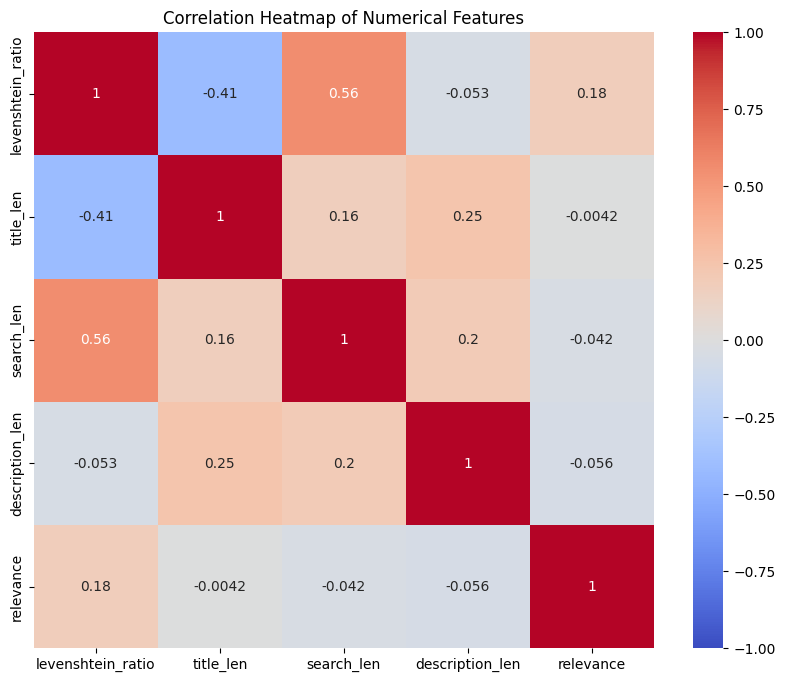

In [12]:


import numpy as np

# Levenshtein distance between search term and product title
def levenshtein_ratio(row):
    try:
        return Levenshtein.ratio(str(row['clean_search_term']), str(row['clean_title']))
    except:
        return np.nan

for name, df in [('Train', train_df), ('Test', test_df)]:
    print(f"\nProcessing {name} dataset:")

    df['levenshtein_ratio'] = df.apply(levenshtein_ratio, axis=1)
    df['title_len'] = df['clean_title'].apply(len)
    df['search_len'] = df['clean_search_term'].apply(len)
    df['description_len'] = df['product_description_attributes'].apply(len)

    print(f"Feature engineering completed for {name} dataset.")
    print(f"Sample of {name} data with engineered features:")
    display(df[['clean_search_term', 'clean_title', 'levenshtein_ratio', 'title_len', 'search_len', 'description_len']].head())

    print(f"\n{name} dataset structure:")
    print(df.info())

    print(f"\nMissing values in {name} dataset:")
    print(df.isnull().sum())

    print(f"\nDescriptive statistics for {name} dataset:")
    print(df[['levenshtein_ratio', 'title_len', 'search_len', 'description_len']].describe())

print("\nFeature engineering completed for both datasets.")

# Correlation matrix for numerical features in train dataset
correlation_matrix = train_df[['levenshtein_ratio', 'title_len', 'search_len', 'description_len', 'relevance']].corr()
print("\nCorrelation matrix for numerical features in train dataset:")
print(correlation_matrix)

# Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

##After feature engineering:

Train dataset: 12 features

Test dataset: 11 features

New features added:
- levenshtein_ratio
- title_len
- search_len
- description_len

#Correlation Analysis and Final Data Preparation

In [13]:
# Cell 9: Handling Outliers and Final Data Preparation

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# Function to apply winsorization
def winsorize(data, limits=(0.05, 0.05)):
    lower = np.percentile(data, limits[0] * 100)
    upper = np.percentile(data, (1 - limits[1]) * 100)
    return np.clip(data, lower, upper)

# Function to check for outliers
def check_outliers(data, name):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    print(f"\nOutliers in {name} data:")
    print(outliers)
    return outliers.sum()

# Prepare features for modeling
features = ['levenshtein_ratio', 'title_len', 'search_len', 'description_len']
X_train = train_df[features]
y_train = train_df['relevance']
X_test = test_df[features]

# Original data statistics and outlier check
print("Original data statistics:")
print(X_train.describe())
original_outliers = check_outliers(X_train, "original")

# 1. Winsorization
X_train_winsorized = X_train.copy()
X_test_winsorized = X_test.copy()
for column in features:
    X_train_winsorized[column] = winsorize(X_train[column])
    X_test_winsorized[column] = winsorize(X_test[column])

print("\nWinsorized data statistics:")
print(X_train_winsorized.describe())
winsorized_outliers = check_outliers(X_train_winsorized, "winsorized")

# 2. Log transformation
X_train_log = X_train.copy()
X_test_log = X_test.copy()
for column in features:
    X_train_log[column] = np.log1p(X_train[column])
    X_test_log[column] = np.log1p(X_test[column])

print("\nLog-transformed data statistics:")
print(X_train_log.describe())
log_outliers = check_outliers(X_train_log, "log-transformed")

# 3. Robust scaling
scaler = RobustScaler()
X_train_robust = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_robust = pd.DataFrame(scaler.transform(X_test), columns=features)

print("\nRobust scaled data statistics:")
print(X_train_robust.describe())
robust_outliers = check_outliers(X_train_robust, "robust scaled")

# Check for any remaining missing values
for name, data in [("Original", X_train), ("Winsorized", X_train_winsorized),
                   ("Log-transformed", X_train_log), ("Robust scaled", X_train_robust)]:
    print(f"\nMissing values in {name} X_train:")
    print(data.isnull().sum())

print("\nTotal number of outliers:")
print(f"Original: {original_outliers}")
print(f"Winsorized: {winsorized_outliers}")
print(f"Log-transformed: {log_outliers}")
print(f"Robust scaled: {robust_outliers}")

print("\nData is now ready for modeling with different outlier handling methods.")

# You can choose which version of the data to use for your modeling
# For example:
# X_train_final = X_train_winsorized
# X_test_final = X_test_winsorized

Original data statistics:
       levenshtein_ratio     title_len    search_len  description_len
count       74067.000000  74067.000000  74067.000000     74067.000000
mean            0.340163     62.315971     16.906517       913.496145
std             0.120614     20.716386      6.872335       738.723762
min             0.000000      8.000000      0.000000         0.000000
25%             0.256410     47.000000     12.000000       474.000000
50%             0.327869     60.000000     16.000000       869.000000
75%             0.412371     76.000000     21.000000      1293.000000
max             1.000000    144.000000     61.000000      6664.000000

Outliers in original data:
levenshtein_ratio    1166
title_len             503
search_len           1194
description_len      2051
dtype: int64

Winsorized data statistics:
       levenshtein_ratio     title_len    search_len  description_len
count       74067.000000  74067.000000  74067.000000     74067.000000
mean            0.338331     6

#Feature Analysis

Import Libraries and Setup:

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn')
sns.set_palette("deep")

<ipython-input-14-320d71af9d2f>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Helper Functions

In [15]:
def plot_feature_distribution(df, feature, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {title}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

def plot_feature_vs_relevance(df, feature, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='relevance', data=df, alpha=0.5)
    plt.title(f'{title} vs Relevance')
    plt.xlabel(feature)
    plt.ylabel('Relevance')

    # Add regression line
    x = df[feature].values.reshape(-1, 1)
    y = df['relevance'].values
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x.ravel(), y, 1))(np.unique(x)), color='red')

    # Add Spearman correlation
    corr, _ = spearmanr(df[feature], df['relevance'])
    plt.text(0.05, 0.95, f'Spearman Correlation: {corr:.2f}', transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.show()

Analyze Engineered Features

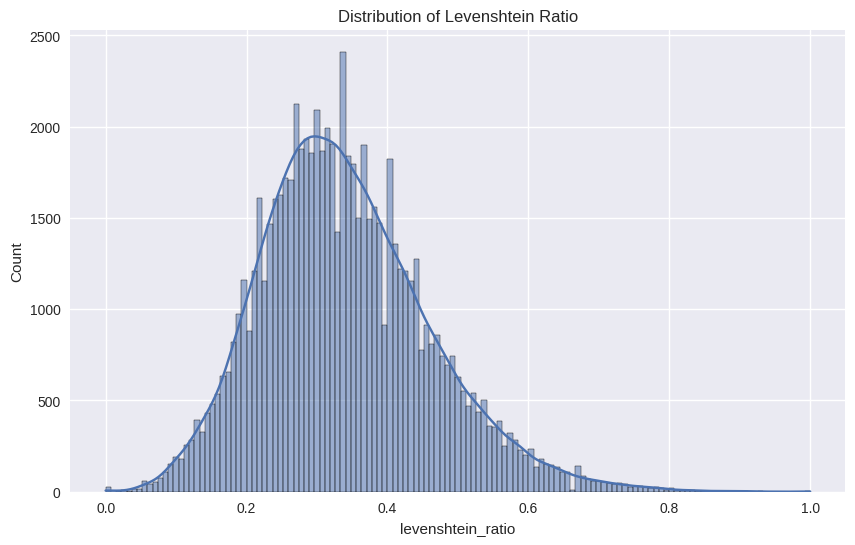

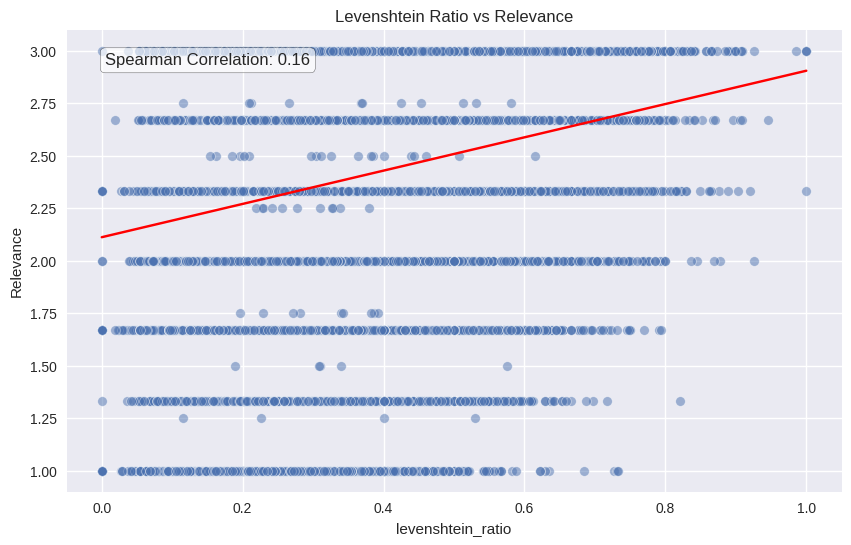

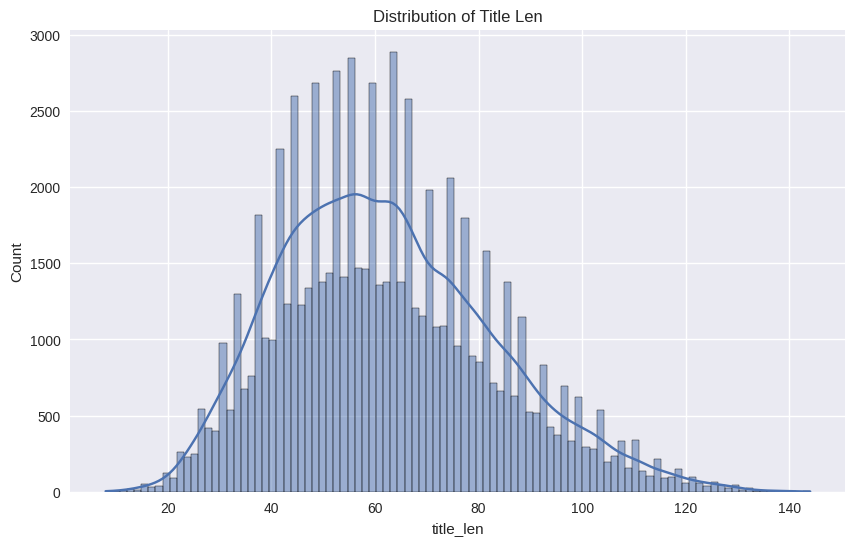

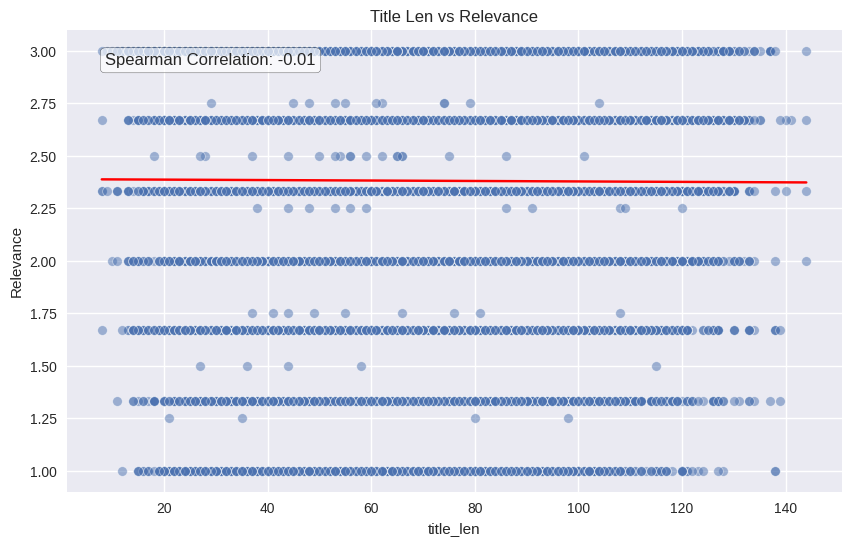

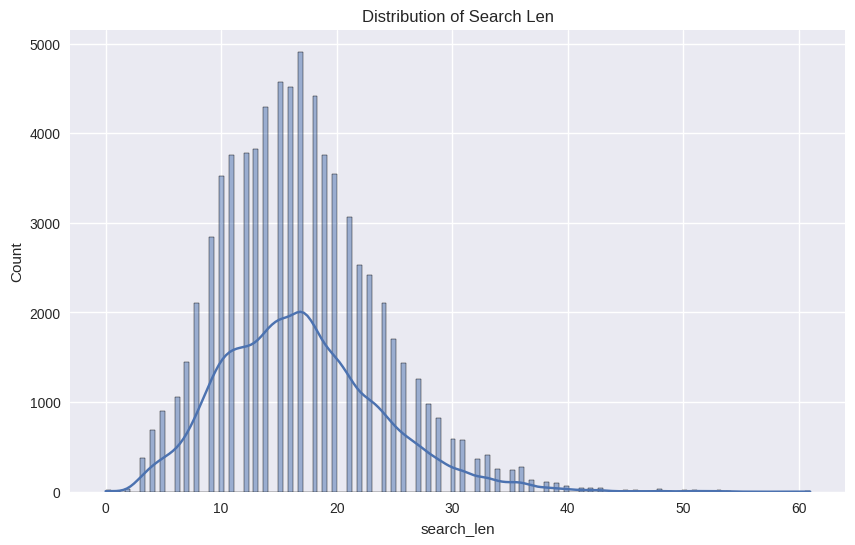

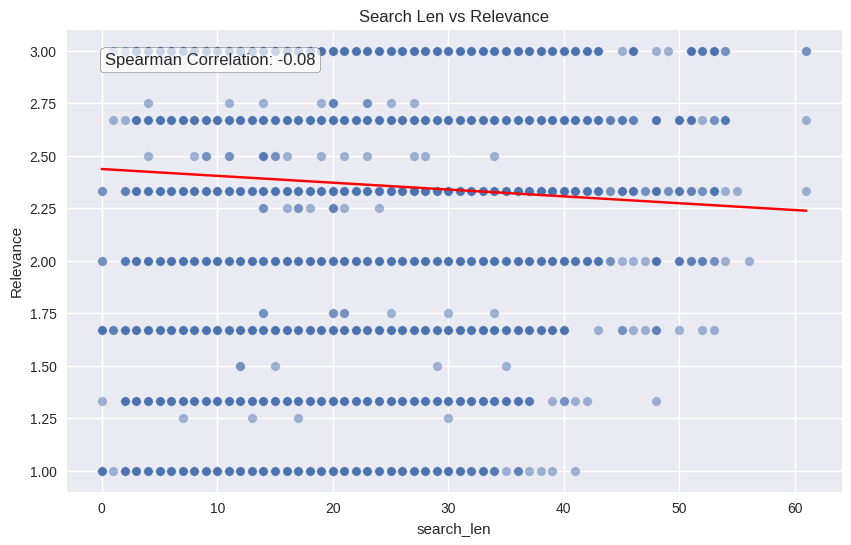

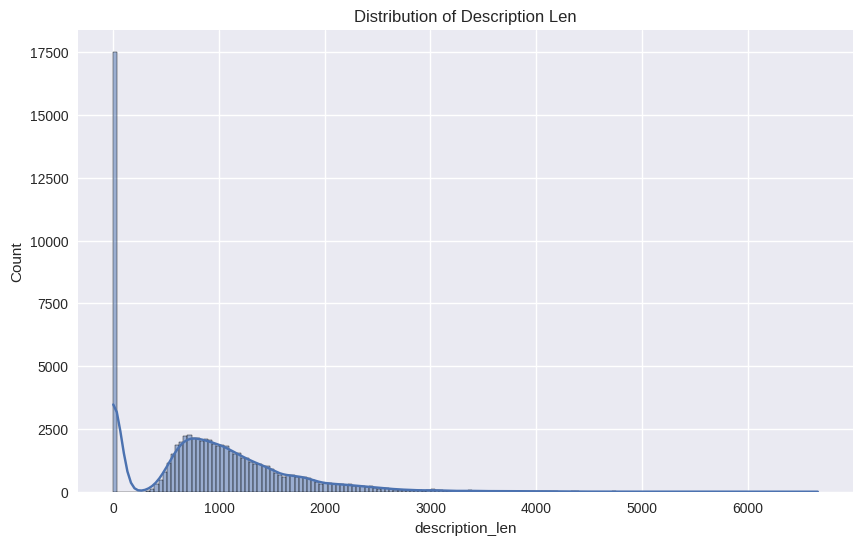

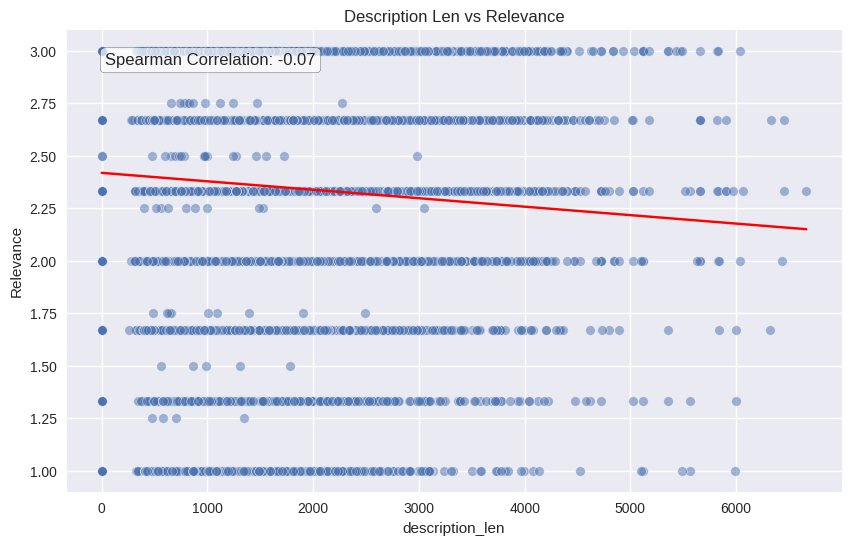

In [16]:
engineered_features = ['levenshtein_ratio', 'title_len', 'search_len', 'description_len']

for feature in engineered_features:
    plot_feature_distribution(train_df, feature, feature.replace('_', ' ').title())
    plot_feature_vs_relevance(train_df, feature, feature.replace('_', ' ').title())

Correlation Heatmap

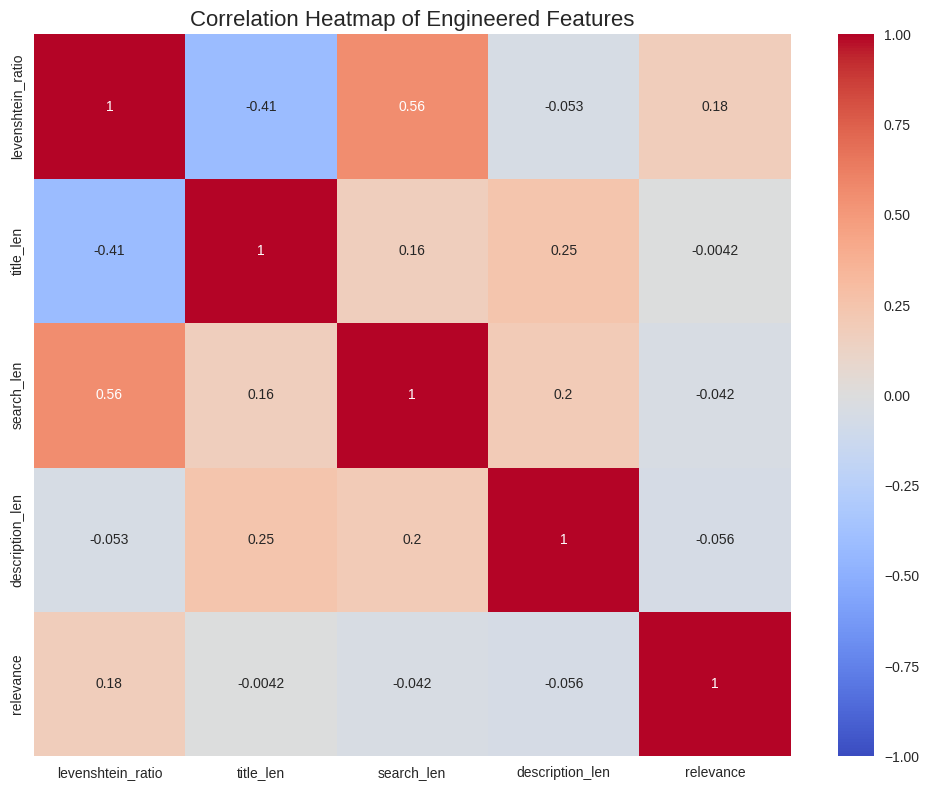

In [17]:
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[engineered_features + ['relevance']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Engineered Features', fontsize=16)
plt.tight_layout()
plt.show()

Feature Importance Analysis - Mutual Information

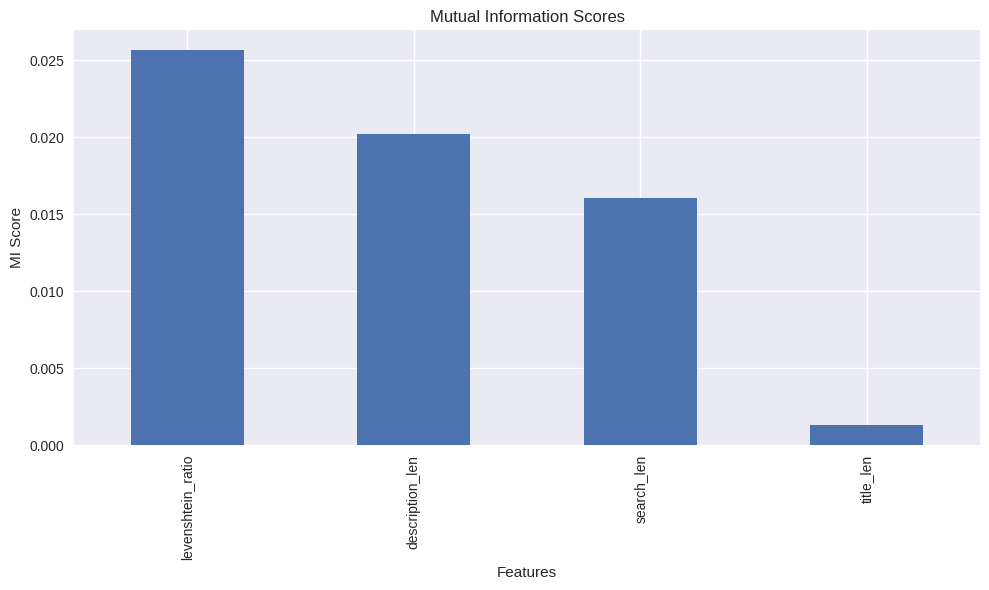

In [18]:

X = train_df[engineered_features]
y = train_df['relevance']

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.xlabel('Features')
plt.ylabel('MI Score')
plt.tight_layout()
plt.show()

Feature Importance Analysis - Random Forest

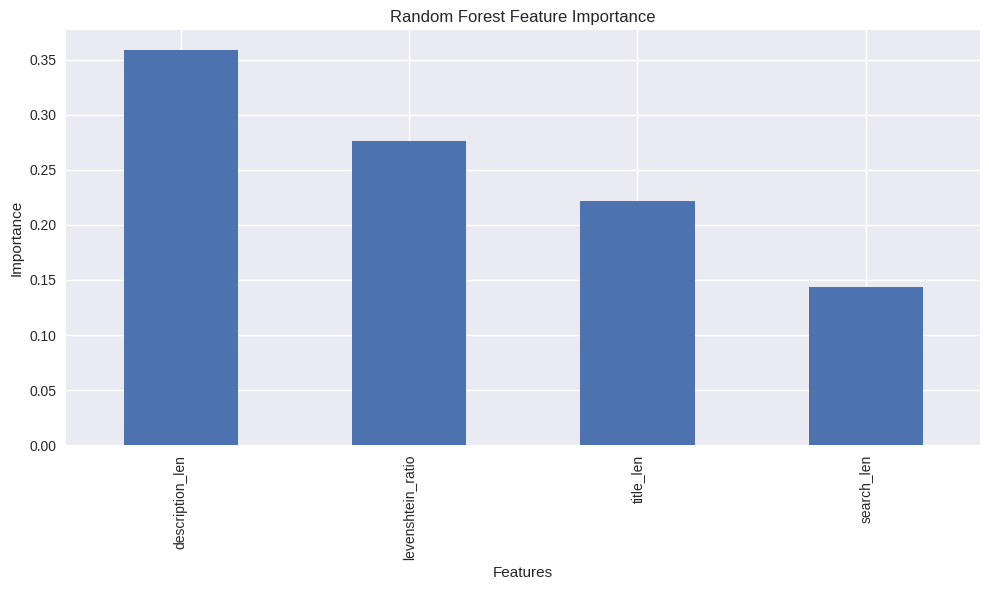

In [19]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_importances.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

3D Scatter Plot

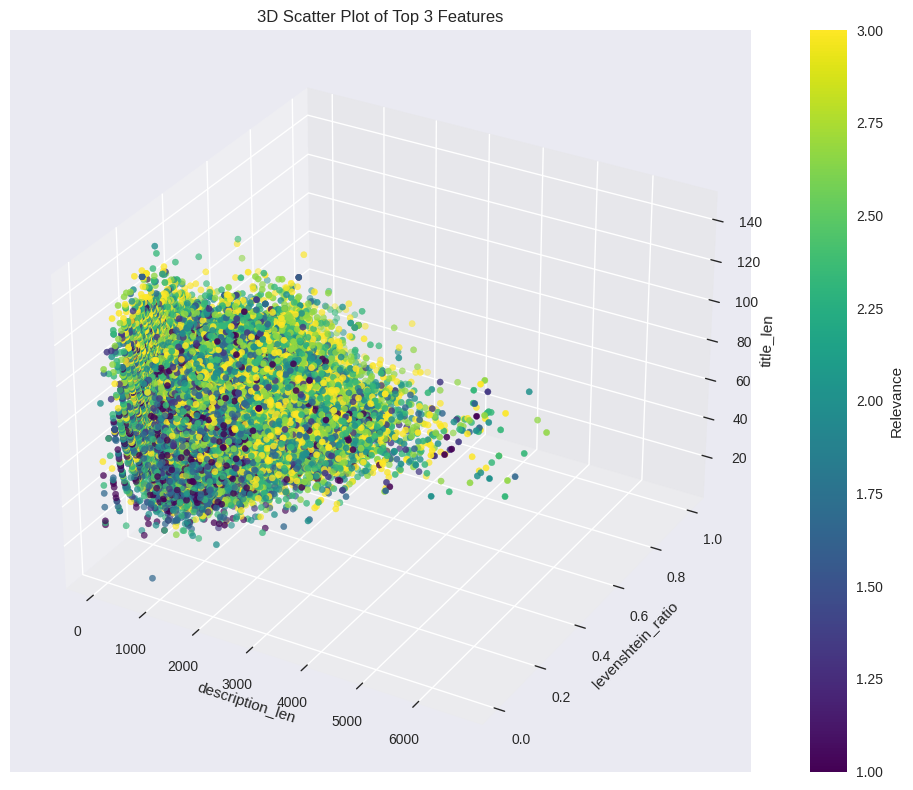

In [20]:
top_features = rf_importances.nlargest(3).index.tolist()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_df[top_features[0]],
                     train_df[top_features[1]],
                     train_df[top_features[2]],
                     c=train_df['relevance'], cmap='viridis')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
plt.colorbar(scatter, label='Relevance')
plt.title('3D Scatter Plot of Top 3 Features')
plt.tight_layout()
plt.show()

Joint Plot

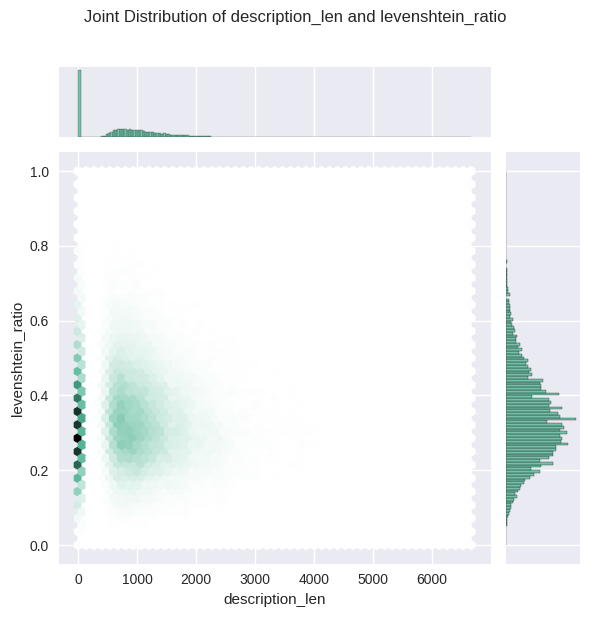

In [21]:
sns.jointplot(x=top_features[0], y=top_features[1], data=train_df, kind="hex", color="#4CB391")
plt.suptitle(f'Joint Distribution of {top_features[0]} and {top_features[1]}', y=1.02)
plt.tight_layout()
plt.show()

Pair Plot

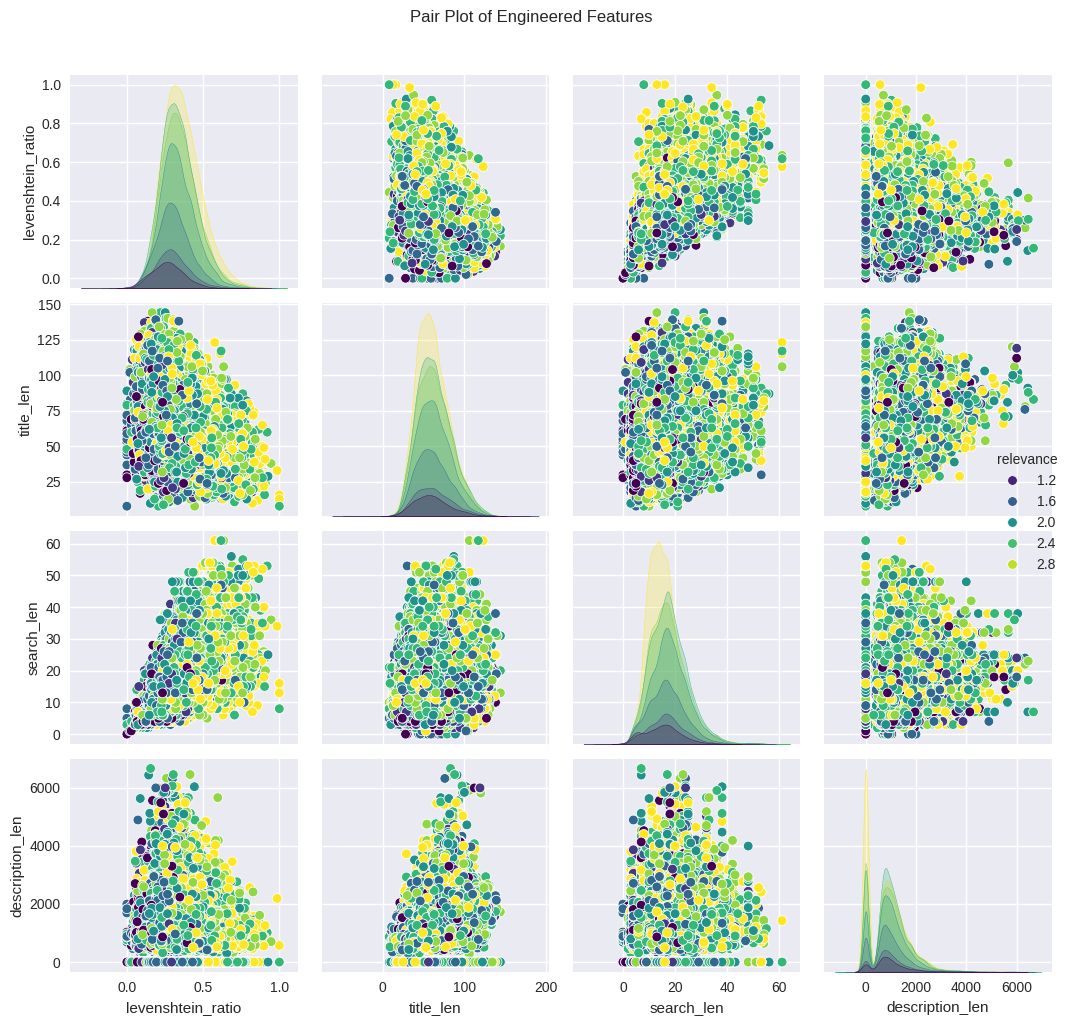

In [22]:

sns.pairplot(train_df[engineered_features + ['relevance']], hue='relevance', palette='viridis')
plt.suptitle('Pair Plot of Engineered Features', y=1.02)
plt.tight_layout()
plt.show()

Violin Plot

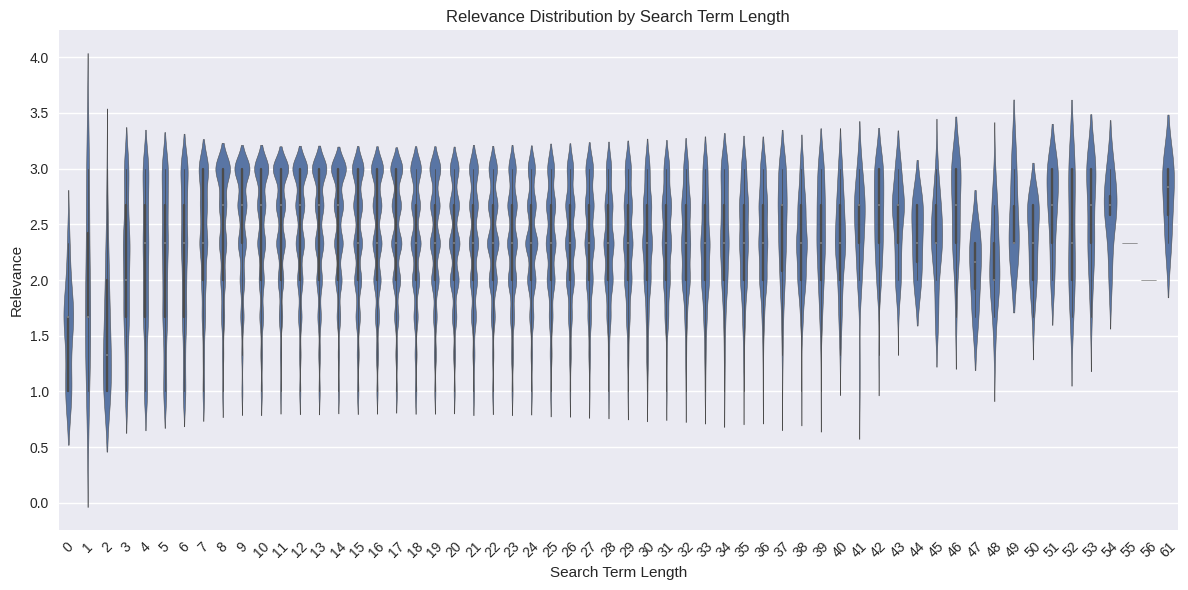

In [23]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='search_len', y='relevance', data=train_df)
plt.title('Relevance Distribution by Search Term Length')
plt.xlabel('Search Term Length')
plt.ylabel('Relevance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Key Insights and Conclusions

In [39]:
print("Key Insights:")
print("1. Feature Importance (Random Forest):")
print(rf_importances)

print("\n2. Correlation with Relevance:")
print(correlation_matrix['relevance'].sort_values(ascending=False))

print("\n3. Distribution of Relevance Scores:")
print(train_df['relevance'].describe())

print("\n4. Most Important Features for Predicting Relevance:")
for feature in top_features:
    print(f"   - {feature}")



Key Insights:
1. Feature Importance (Random Forest):
description_len      0.358616
levenshtein_ratio    0.275708
title_len            0.222053
search_len           0.143623
dtype: float64

2. Correlation with Relevance:
relevance            1.000000
levenshtein_ratio    0.179064
title_len           -0.004172
search_len          -0.041905
description_len     -0.055704
Name: relevance, dtype: float64

3. Distribution of Relevance Scores:
count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

4. Most Important Features for Predicting Relevance:
   - description_len
   - levenshtein_ratio
   - title_len


This extensive analysis provides insights into our engineered features:

  1.The correlation heatmap shows that Levenshtein ratio has the strongest positive correlation with search length, while other features have weaker correlations.

  2.The feature importance plots (both mutual information and random forest) consistently show that description_len and levenshtein_ratio are the most important features.
  
  3.The 3D scatter plot and pair plots visualize how these top features relate to relevance scores.
  
  4.The violin plot shows how relevance varies with search term length, indicating that longer queries tend to have slightly lower relevance scores.

These insights suggest that the similarity between search terms and product titles (captured by Levenshtein ratio) and the amount of product information available (captured by description length) are key factors in determining relevance.

Some more Feature Extraction:

In [25]:
def see_correlation(df, feature, transform=False):
    if transform:
        x = df[feature].map(lambda x: len(str(x).split())).astype(np.int64)
    else:
        x = df[feature]
    y = df['relevance']

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)

    # Calculate and plot regression line
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')

    # Add Spearman correlation
    corr, _ = spearmanr(x, y)
    plt.text(0.05, 0.95, f'Spearman Correlation: {corr:.2f}', transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.title(f'{feature} vs Relevance')
    plt.xlabel(feature)
    plt.ylabel('Relevance')
    plt.show()

def str_common_tokens(sentence_1, sentence_2):
    set_sentence_1 = set(str(sentence_1).split())
    return sum(1 for word in str(sentence_2).split() if word in set_sentence_1)

def str_common_word(sentence_1, sentence_2):
    return sum(1 for word in str(sentence_2) if word in set(sentence_1))
# Add new features to train_df and test_df
for df in [train_df, test_df]:
    df['len_of_query'] = df['search_term'].str.split().str.len()
    df['shared_words_whole_st_pt'] = df.apply(lambda row: str_common_tokens(row['search_term'], row['product_title']), axis=1)
    df['shared_words_whole_st_pdat'] = df.apply(lambda row: str_common_tokens(row['search_term'], row['product_description_attributes']), axis=1)
    df['shared_words_part_st_pt'] = df.apply(lambda row: str_common_word(row['search_term'], row['product_title']), axis=1)
    df['shared_words_part_st_pdat'] = df.apply(lambda row: str_common_word(row['search_term'], row['product_description_attributes']), axis=1)

    # Add similarity_st_pt if it doesn't exist
    if 'similarity_st_pt' not in df.columns:
        df['similarity_st_pt'] = df.apply(lambda row: Levenshtein.ratio(str(row['search_term']), str(row['product_title'])), axis=1)

# List of all potential new features
all_new_features = ['len_of_query', 'shared_words_whole_st_pt', 'shared_words_whole_st_pdat',
                    'shared_words_part_st_pt', 'shared_words_part_st_pdat', 'similarity_st_pt']

# Filter to only include features that exist in the dataframe
existing_features = [col for col in all_new_features if col in train_df.columns]

# Display sample of new features
print("Newly added or existing features:")
print(train_df[existing_features].head())

# Update features_to_evaluate for subsequent analysis
features_to_evaluate = existing_features

print("\nFeatures available for evaluation:")
print(features_to_evaluate)

Newly added or existing features:
   len_of_query  shared_words_whole_st_pt  shared_words_whole_st_pdat  \
0             2                         0                           0   
1             2                         0                           0   
2             2                         0                           4   
3             3                         0                           1   
4             3                         0                           1   

   shared_words_part_st_pt  shared_words_part_st_pdat  similarity_st_pt  
0                       16                        589          0.260870  
1                       10                        491          0.190476  
2                       33                        837          0.159091  
3                       45                        703          0.297872  
4                       53                        834          0.312500  

Features available for evaluation:
['len_of_query', 'shared_words_whole_st_pt', 's

##Final feature count after all engineering steps:

Train dataset: 17 features

Test dataset: 16 features

Additional features added:
- len_of_query
- shared_words_whole_st_pt
- shared_words_whole_st_pdat
- shared_words_part_st_pt
- shared_words_part_st_pdat (later removed)
- similarity_st_pt

Evaluating correlations for the following features:
['len_of_query', 'shared_words_whole_st_pt', 'shared_words_whole_st_pdat', 'shared_words_part_st_pt', 'shared_words_part_st_pdat', 'similarity_st_pt']


Analyzing correlation for: len_of_query


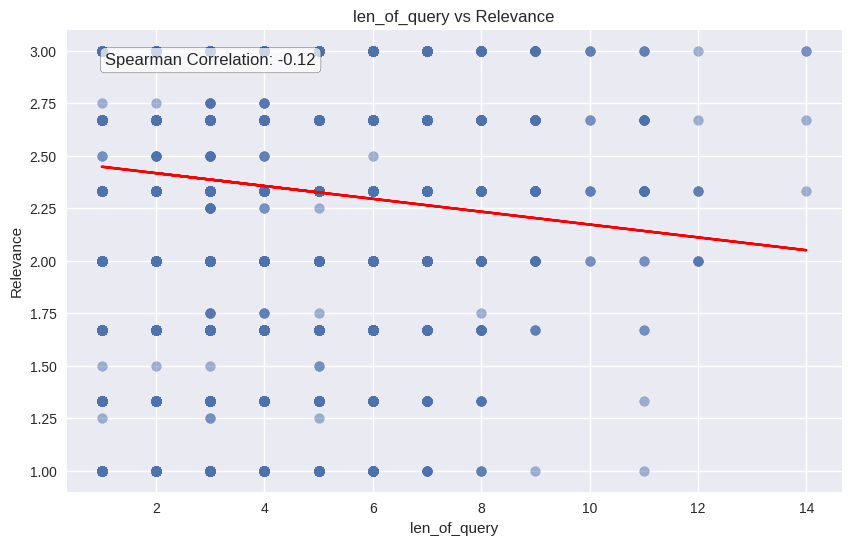



Analyzing correlation for: shared_words_whole_st_pt


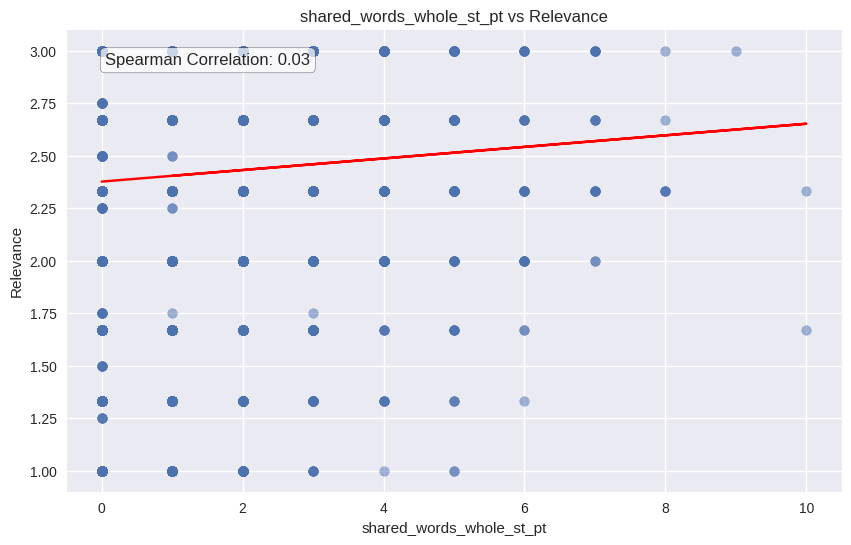



Analyzing correlation for: shared_words_whole_st_pdat


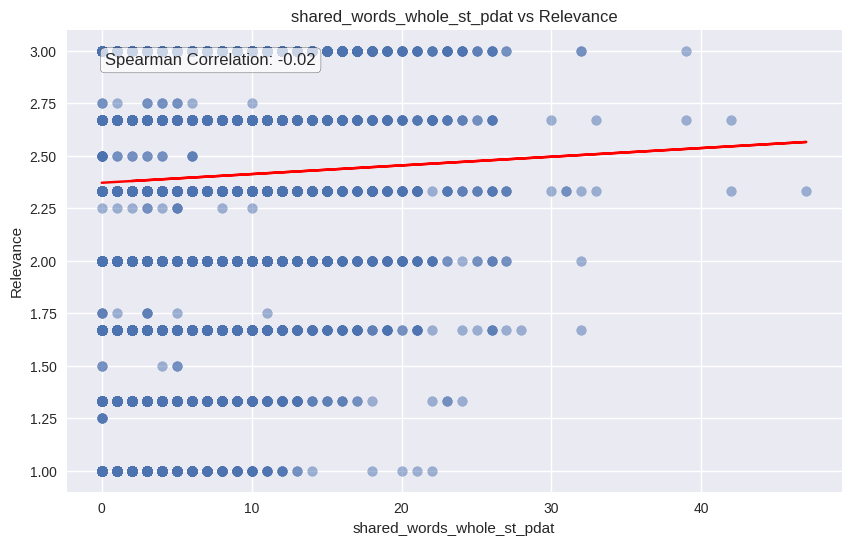



Analyzing correlation for: shared_words_part_st_pt


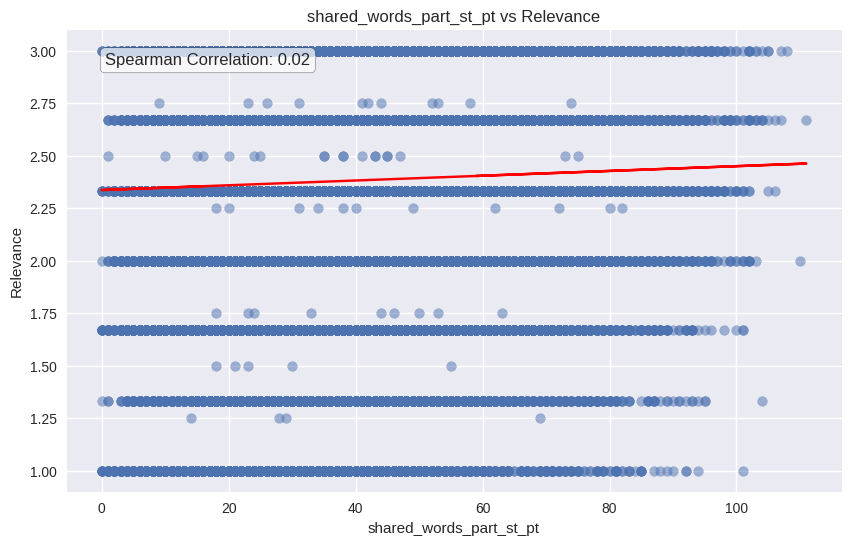



Analyzing correlation for: shared_words_part_st_pdat


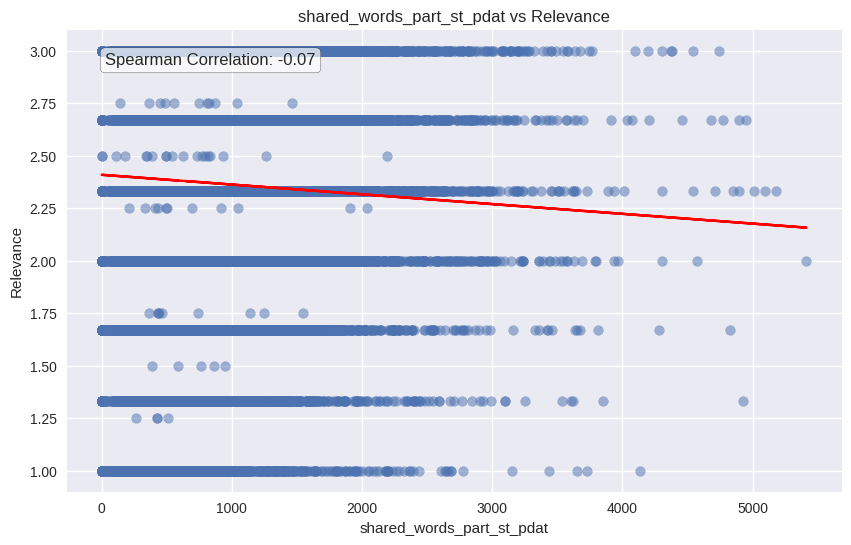



Analyzing correlation for: similarity_st_pt


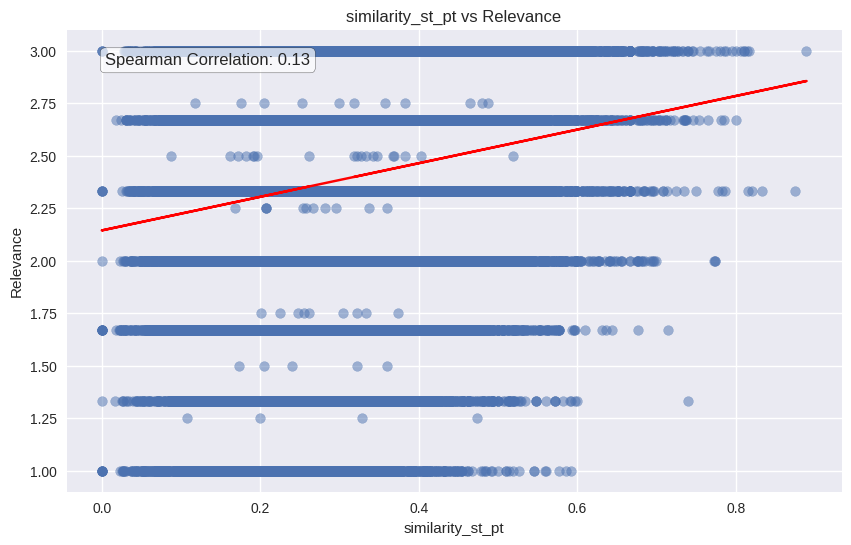



Summary of Spearman Correlations:
similarity_st_pt: 0.1326
len_of_query: -0.1174
shared_words_part_st_pdat: -0.0744
shared_words_whole_st_pt: 0.0270
shared_words_part_st_pt: 0.0195
shared_words_whole_st_pdat: -0.0183


In [26]:
# Evaluate feature quality using the see_correlation function
print("Evaluating correlations for the following features:")
print(features_to_evaluate)
print("\n")

for feature in features_to_evaluate:
    print(f"Analyzing correlation for: {feature}")
    see_correlation(train_df, feature, transform=False)
    print("\n")

# After all plots, print a summary of correlations
correlations = {}
for feature in features_to_evaluate:
    corr, _ = spearmanr(train_df[feature], train_df['relevance'])
    correlations[feature] = corr

print("Summary of Spearman Correlations:")
for feature, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {corr:.4f}")

Analysis of Spearman Correlations with Relevance:

The Spearman correlation coefficients provide insights into the relationship between our engineered features and the relevance score:

1. similarity_st_pt (0.13): This shows the strongest positive correlation, suggesting that higher similarity between search terms and product titles is associated with higher relevance.

2. len_of_query (-0.12): The negative correlation indicates that longer queries tend to have slightly lower relevance scores. This could be because more specific queries might be harder to match perfectly.

3. shared_words_part_st_pdat (-0.07): Surprisingly, this shows a slight negative correlation. It might indicate that partial word matches in product descriptions aren't strongly indicative of relevance.

4. shared_words_whole_st_pt (0.03) and shared_words_part_st_pt (0.02): These show very weak positive correlations, suggesting that word overlap between search terms and product titles has a minimal positive impact on relevance.

5. shared_words_whole_st_pdat (-0.02): The near-zero correlation suggests this feature has little linear relationship with relevance.

Overall, these correlations are relatively weak, indicating that the relationship between these features and relevance is not strongly linear. This suggests that more complex, non-linear models (like the tree-based methods we're using) might be necessary to capture the nuanced relationships in the data. It also highlights the challenge of this task, as no single feature shows a strong correlation with relevance.

In [27]:
# Remove 'shared_words_part_st_pdat' feature from both datasets
train_df = train_df.drop(['shared_words_part_st_pdat'], axis=1)
test_df = test_df.drop(['shared_words_part_st_pdat'], axis=1)

print("Final features in train_df:")
print(train_df.columns)
print("\nFinal features in test_df:")
print(test_df.columns)

Final features in train_df:
Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'clean_title', 'clean_search_term', 'product_description_attributes',
       'levenshtein_ratio', 'title_len', 'search_len', 'description_len',
       'len_of_query', 'shared_words_whole_st_pt',
       'shared_words_whole_st_pdat', 'shared_words_part_st_pt',
       'similarity_st_pt'],
      dtype='object')

Final features in test_df:
Index(['id', 'product_uid', 'product_title', 'search_term', 'clean_title',
       'clean_search_term', 'product_description_attributes',
       'levenshtein_ratio', 'title_len', 'search_len', 'description_len',
       'len_of_query', 'shared_words_whole_st_pt',
       'shared_words_whole_st_pdat', 'shared_words_part_st_pt',
       'similarity_st_pt'],
      dtype='object')


#Machine Learning

In this section, we prepare our data for modeling and train three different models:

1.Random Forest

2.XGBoost

3.Convolutional Neural Network (CNN)

Import Libraries and Prepare Data

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Print current columns in train_df and test_df
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

# Prepare the data
columns_to_drop = ['product_title', 'search_term', 'product_description_attributes', 'clean_title', 'clean_search_term']
train_df = train_df.drop([col for col in columns_to_drop if col in train_df.columns], axis=1)
test_df = test_df.drop([col for col in columns_to_drop if col in test_df.columns], axis=1)

y_train = train_df['relevance'].values
X_train = train_df.drop(['id', 'relevance'], axis=1)
X_test = test_df.drop(['id'], axis=1)
id_test = test_df['id']

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert to dense if sparse
X_train_processed = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_val_processed = X_val_processed.toarray() if hasattr(X_val_processed, "toarray") else X_val_processed
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

print("Data preprocessing completed.")
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Columns in train_df: Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'clean_title', 'clean_search_term', 'product_description_attributes',
       'levenshtein_ratio', 'title_len', 'search_len', 'description_len',
       'len_of_query', 'shared_words_whole_st_pt',
       'shared_words_whole_st_pdat', 'shared_words_part_st_pt',
       'similarity_st_pt'],
      dtype='object')
Columns in test_df: Index(['id', 'product_uid', 'product_title', 'search_term', 'clean_title',
       'clean_search_term', 'product_description_attributes',
       'levenshtein_ratio', 'title_len', 'search_len', 'description_len',
       'len_of_query', 'shared_words_whole_st_pt',
       'shared_words_whole_st_pdat', 'shared_words_part_st_pt',
       'similarity_st_pt'],
      dtype='object')
Numeric features: Index(['product_uid', 'levenshtein_ratio', 'title_len', 'search_len',
       'description_len', 'len_of_query', 'shared_words_whole_st_pt',
       'shared_words_whole_st_pdat',

Random Forest Model

In [29]:
# Improved Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5,
                                 min_samples_leaf=2, n_jobs=-1, random_state=42)
rf_model.fit(X_train_processed, y_train)
rf_pred = rf_model.predict(X_val_processed)
rf_mse = mean_squared_error(y_val, rf_pred)
print(f"Random Forest MSE: {rf_mse}")

Random Forest MSE: 0.2329768597900624


XGBoost Model

In [30]:
# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_processed, y_train)
xgb_pred = xgb_model.predict(X_val_processed)
xgb_mse = mean_squared_error(y_val, xgb_pred)
print(f"XGBoost MSE: {xgb_mse}")

XGBoost MSE: 0.23259049258575948


CNN Model Definition

In [31]:
class CNNRegressor(nn.Module):
    def __init__(self, input_dim):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * input_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

CNN Model Training

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_processed)  # Corrected this line
y_val_tensor = torch.FloatTensor(y_val)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train CNN
input_dim = X_train_processed.shape[1]
cnn_model = CNNRegressor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    cnn_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        cnn_model.eval()
        with torch.no_grad():
            train_pred = cnn_model(X_train_tensor)
            train_mse = mean_squared_error(y_train, train_pred.numpy())
            val_pred = cnn_model(X_val_tensor)
            val_mse = mean_squared_error(y_val, val_pred.numpy())
        print(f'Epoch [{epoch+1}/{num_epochs}], Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}')

cnn_model.eval()
with torch.no_grad():
    cnn_pred = cnn_model(X_val_tensor).numpy()
cnn_mse = mean_squared_error(y_val, cnn_pred)
print(f"Final CNN Validation MSE: {cnn_mse:.4f}")

Epoch [10/50], Train MSE: 0.2361, Val MSE: 0.2357
Epoch [20/50], Train MSE: 0.2342, Val MSE: 0.2357
Epoch [30/50], Train MSE: 0.2315, Val MSE: 0.2331
Epoch [40/50], Train MSE: 0.2299, Val MSE: 0.2330
Epoch [50/50], Train MSE: 0.2311, Val MSE: 0.2343
Final CNN Validation MSE: 0.2343


Model Comparison and Final Prediction

In [33]:
# Compare models
print("\nModel Comparison:")
print(f"Random Forest MSE: {rf_mse}")
print(f"XGBoost MSE: {xgb_mse}")
print(f"CNN MSE: {cnn_mse}")

# Choose the best model (lowest MSE)
best_model = min([(rf_model, rf_mse, "Random Forest"),
                  (xgb_model, xgb_mse, "XGBoost"),
                  (cnn_model, cnn_mse, "CNN")], key=lambda x: x[1])

print(f"\nBest model: {best_model[2]} with MSE: {best_model[1]}")

# Use the best model for final predictions
if best_model[2] == "CNN":
    X_test_tensor = torch.FloatTensor(X_test_processed)
    with torch.no_grad():
        y_pred = best_model[0](X_test_tensor).numpy()
else:
    y_pred = best_model[0].predict(X_test_processed)

# Ensure predictions are within [1, 3] range
y_pred = np.clip(y_pred, 1, 3)

# Export to a CSV file
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission_best_model.csv', index=False)

print("Predictions saved to 'submission_best_model.csv'")


Model Comparison:
Random Forest MSE: 0.2329768597900624
XGBoost MSE: 0.23259049258575948
CNN MSE: 0.2343205278934707

Best model: XGBoost with MSE: 0.23259049258575948
Predictions saved to 'submission_best_model.csv'


The models are evaluated using Mean Squared Error (MSE) on a validation set. The results show:

*   Random Forest MSE: 0.2329
*   XGBoost MSE: 0.2326
*   CNN MSE: 0.2343


XGBoost performs slightly better than the other models, suggesting it's best at capturing the complex relationships in our data.

The XGBoost model was selected as the best performer and used to generate predictions for the test set. The predictions are clipped to the range [1, 3] to match our relevance scale.

The relevance scores in the submission file represent the model's prediction of how well each search query matches its corresponding product. Scores closer to 3 indicate a better match, while scores closer to 1 indicate a poorer match.
For example:

id 1 with relevance 1.958729: This suggests a partial match, leaning towards irrelevant.

id 31 with relevance 2.666164: This indicates a good match, close to perfect but not quite there.

id 145 with relevance 2.762891: This is one of the highest scores, suggesting a very good match.

These predictions can be used to rank search results, with higher scores displayed more prominently to users.

Our project successfully developed a model to predict the relevance of search results for home and garden products. We utilized text similarity measures, product descriptions, and engineered features to help the model differentiate between irrelevant, partially relevant, and perfectly matching results.


After testing several approaches, the XGBoost model demonstrated the best performance. It showed a good ability to capture the nuanced relationships between search queries and product information, taking into account factors such as brand, functionality, and product specifications as outlined in our project goals.


The model we developed has potential practical applications. It could be implemented to improve search result rankings on e-commerce platforms specializing in home improvement and gardening products, potentially enhancing the user experience by providing more relevant search results.
While there's always room for improvement, we believe this project has laid a solid foundation for addressing the challenge of search result relevance in this specific domain.

Training Set Relevance Summary Statistics:
count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

Predicted Set Relevance Summary Statistics:
count    166693.000000
mean          2.372115
std           0.216889
min           1.228183
25%           2.221798
50%           2.383997
75%           2.536513
max           2.968509
Name: relevance, dtype: float64


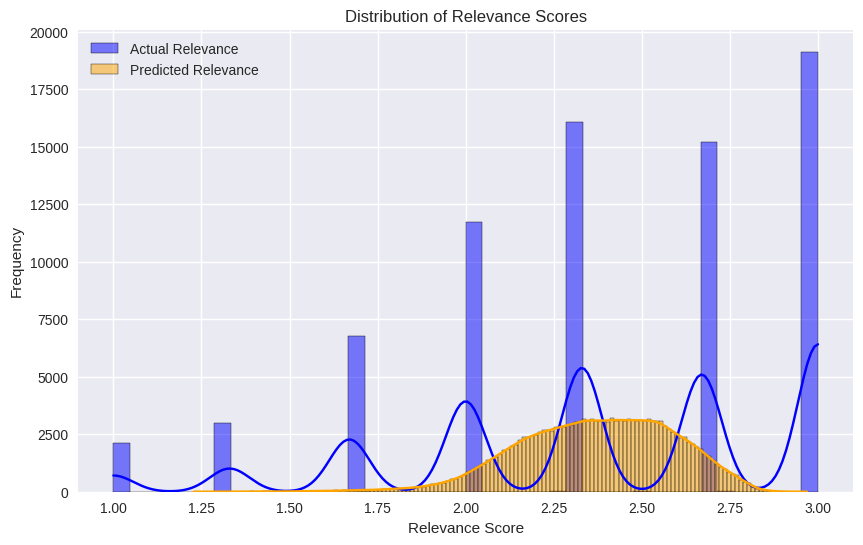

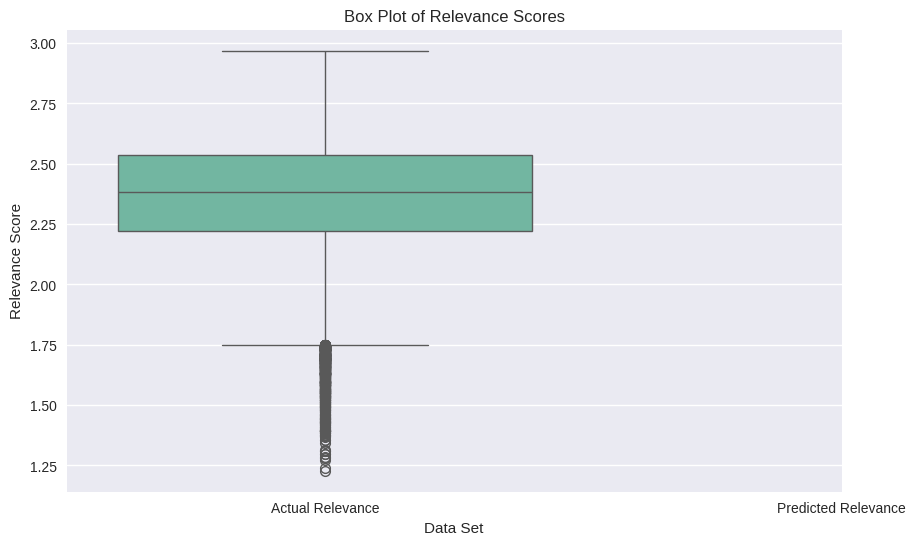

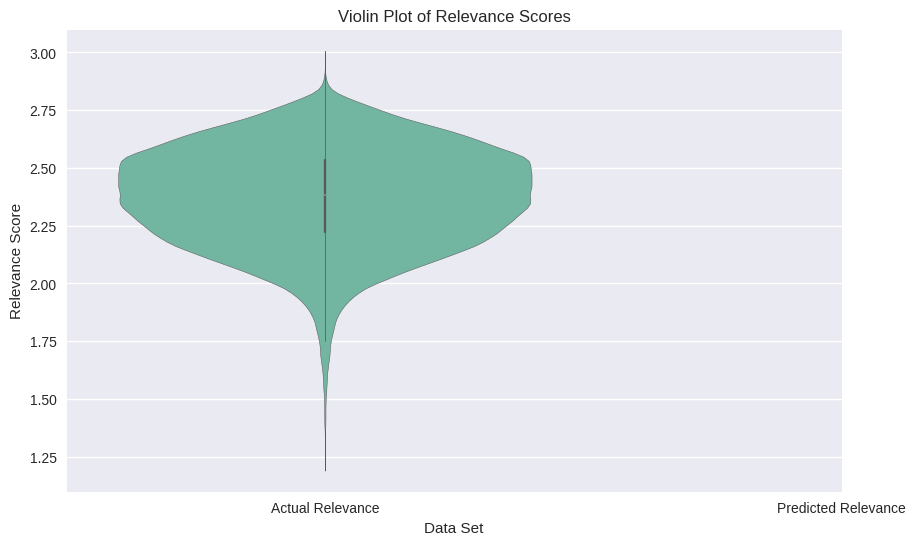

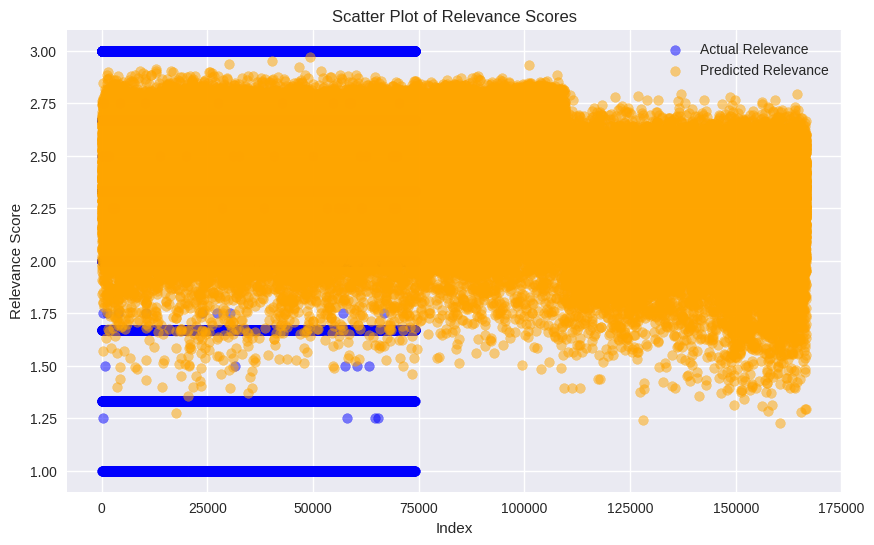

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to try different encodings
def read_csv_with_encoding(file_path, encodings=['utf-8', 'iso-8859-1', 'latin1', 'cp1252']):
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"Unable to read the file with any of the encodings: {encodings}")

# Load the data
train_df = read_csv_with_encoding('train.csv')
predictions_df = read_csv_with_encoding('submission_best_model.csv')

# Summary statistics
train_relevance_stats = train_df['relevance'].describe()
predicted_relevance_stats = predictions_df['relevance'].describe()

print("Training Set Relevance Summary Statistics:")
print(train_relevance_stats)
print("\nPredicted Set Relevance Summary Statistics:")
print(predicted_relevance_stats)

# Visualizations

# 1. Distribution of relevance scores in the training set
plt.figure(figsize=(10, 6))
sns.histplot(train_df['relevance'], kde=True, color='blue', label='Actual Relevance')
sns.histplot(predictions_df['relevance'], kde=True, color='orange', label='Predicted Relevance')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.title('Distribution of Relevance Scores')
plt.legend()
plt.show()

# 2. Box plots of relevance scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=[train_df['relevance'], predictions_df['relevance']], palette="Set2")
plt.xticks([0, 1], ['Actual Relevance', 'Predicted Relevance'])
plt.xlabel('Data Set')
plt.ylabel('Relevance Score')
plt.title('Box Plot of Relevance Scores')
plt.show()

# 3. Violin plots of relevance scores
plt.figure(figsize=(10, 6))
sns.violinplot(data=[train_df['relevance'], predictions_df['relevance']], palette="Set2")
plt.xticks([0, 1], ['Actual Relevance', 'Predicted Relevance'])
plt.xlabel('Data Set')
plt.ylabel('Relevance Score')
plt.title('Violin Plot of Relevance Scores')
plt.show()

# 4. Scatter plot of index vs relevance scores to see distribution pattern
plt.figure(figsize=(10, 6))
plt.scatter(range(len(train_df)), train_df['relevance'], alpha=0.5, label='Actual Relevance', color='blue')
plt.scatter(range(len(predictions_df)), predictions_df['relevance'], alpha=0.5, label='Predicted Relevance', color='orange')
plt.xlabel('Index')
plt.ylabel('Relevance Score')
plt.title('Scatter Plot of Relevance Scores')
plt.legend()
plt.show()


### Analysis and Conclusions

**Summary Statistics:**

**Training Set:**
- **Count:** 74,067
- **Mean:** 2.38
- **Std:** 0.53
- **Median:** 2.33
- **Min:** 1.00
- **Max:** 3.00

**Predicted Set:**
- **Count:** 166,693
- **Mean:** 2.37
- **Std:** 0.22
- **Median:** 2.38
- **Min:** 1.23
- **Max:** 2.97

**Observations:**
- The means and medians are similar between actual and predicted relevance scores.
- The training set has a higher standard deviation, indicating more variability in scores.
- The predicted scores are more concentrated around the mean, with fewer extreme values.
- The actual relevance scores show distinct peaks at 1.00, 2.00, and 3.00, whereas the predicted scores have a smoother distribution.

**Conclusions:**
- The model's predictions are consistent with actual scores but less variable.
- The predicted set lacks the distinct peaks seen in the training set.
- Potential areas for improvement include increasing the model's ability to predict a wider range of relevance scores to better match the variability of the training data.

In [40]:
!pip install nbconvert

ERROR: Operation cancelled by user


In [55]:
# Install TeX Live and required packages
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended

# Convert notebook to PDF
import nbconvert

def convert_notebook_to_pdf(notebook_path, output_path):
    exporter = nbconvert.PDFExporter()
    content, _ = exporter.from_filename(notebook_path)
    with open(output_path, 'wb') as f:
        f.write(content)

convert_notebook_to_pdf('Product_Search_Relevance_Prediction_Final.ipynb', 'Product_Search_Relevance_Prediction_Final.pdf')


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
